In [126]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import time
import sys
import multiprocessing
from collections import OrderedDict, defaultdict
from itertools import product
from copy import deepcopy, copy
from namegenerator import NameGenerator

import gym
import rubiks

# Debugging and profiling
import cProfile
import ipdb
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

TODO:
    - Add Bias term
    - Custom weights
    - Drop out connections (set weight to 0)
    - Custom activation per node
    
    - Add function that resets stagnation for all species
    - Network Visualisation
    - Species Visualisation
    - Seed

# Activation functions

In [2]:
def leaky_relu(x):
    return F.leaky_relu(x)

def tanh(x):
    return torch.tanh(x)

def relu(x):
    return F.relu(x)

def sigmoid(x):
    return torch.sigmoid(x)

def identity(x):
    return x

string_to_activation = {
    'leaky_relu' : leaky_relu,
    'relu' : relu,
    'sigmoid' : sigmoid,
    'tanh' : tanh,
    'identity' : identity
}

# Model

In [3]:
class Model(nn.Module):
    def __init__(self,layer_sizes):
        super(Model, self).__init__()
        layers = OrderedDict()
        
        previous_layer_size = layer_sizes[0]
        for idx, current_layer_size in enumerate(layer_sizes[1:]):
            layers[str(idx)] = nn.Linear(previous_layer_size, current_layer_size)
            previous_layer_size = current_layer_size
            
        self.layers = nn.Sequential(layers)
        
    def forward(self, x):
        return self.model(x)

In [89]:
firstname_generator = NameGenerator('names.csv', 3, 12)
new_individual_name = firstname_generator.generate_name()
previous_names = []
surname_generator = NameGenerator('surnames.csv', 3, 12)
new_specie_name = surname_generator.generate_name()
previous_surnames = []

# Genotype

In [90]:
class Genotype(object):
    def __init__(self, 
                 inputs = 144, 
                 outputs = 12, 
                 nonlinearities = ['relu','sigmoid','tanh'],
                 topology = None,
                 feedforward = True,
                 max_depth = None,
                 max_nodes = float('inf'),
                 response_default = 4.924273,
                 initial_weight_stdev = 2.0,
                 bias_as_node = False,
                 p_add_neuron = 0.03, 
                 p_add_connection = 0.3, 
                 p_mutate_weight = 0.8,
                 p_reset_weight = 0.1,
                 p_reenable_connection = 0.01,
                 p_disable_connection = 0.01, 
                 p_reenable_parent = 0.25, 
                 p_mutate_bias = 0.2,
                 p_mutate_response = 0.0,
                 p_mutate_type = 0.2,
                 stdev_mutate_weight = 1.5,
                 stdev_mutate_bias = 0.5,
                 stdev_mutate_response = 0.5,
                 weight_range = (-50.,50.),
                 distance_excess_weight = 1.0, 
                 distance_disjoint_weight = 1.0, 
                 distance_weight = 0.4):
        
        self.name = next(new_individual_name)
        self.specie = None
        
        self.inputs = inputs
        self.outputs = outputs
        self.nonlinearities = nonlinearities
        self.feedforward = feedforward
        self.bias_as_node = bias_as_node
        
        self.max_depth = max_depth
        self.max_nodes = max_nodes
        
        self.response_default = response_default
        self.initial_weight_stdev = initial_weight_stdev
        self.stdev_mutate_weight = stdev_mutate_weight
        self.stdev_mutate_bias = stdev_mutate_bias
        self.stdev_mutate_response = stdev_mutate_response
        self.weight_range = weight_range
        
        # Mutation Probabilities
        self.p_add_neuron = p_add_neuron
        self.p_add_connection = p_add_connection
        self.p_mutate_weight = p_mutate_weight
        self.p_reset_weight = p_reset_weight
        self.p_reenable_connection = p_reenable_connection
        self.p_disable_connection = p_disable_connection
        self.p_reenable_parent = p_reenable_parent
        self.p_mutate_bias = p_mutate_bias
        self.p_mutate_response = p_mutate_response
        self.p_mutate_type = p_mutate_type
        
        # Distance weights
        self.distance_excess_weight = distance_excess_weight
        self.distance_disjoint_weight = distance_disjoint_weight
        self.distance_weight = distance_weight
        
        # Tuples of: id, non_linearity, bias, layer, ff_order, response
        self.neuron_genes = []
        # Tuples of: innovation number, input, output, weight, enabled
        self.connection_genes = {}
        # Hyperparameter genes
        self.hyperparameter_genes = []
        
        self.input_keys = []
        self.output_keys = []
        
        self._initialise_topology(topology)
    
    def change_specie(self,specie):
        self.specie = specie
        
    def _initialise_topology(self, topology):
#         if self.bias_as_node:
#             self.inputs += 1
        
        self.max_layer = 2048 if (self.max_depth is None) else (self.max_depth - 1)
        
        if topology is None:
            # Initialise inputs
            for i in range(self.inputs):
                self.neuron_genes.append([i, random.choice(self.nonlinearities),1.0,0, i * 2048, self.response_default])
                self.input_keys.append(i)
            # Initialise outputs
            for i in range(self.outputs):
                self.neuron_genes.append([(self.inputs + i), random.choice(self.nonlinearities),1.0,self.max_layer, (self.inputs + i) * 2048, self.response_default])
                self.output_keys.append((self.inputs + i))
            # Initialise connections
            innovation_number = 0
            for i in range(self.inputs):
                for j in range(self.inputs,self.inputs + self.outputs):
                    weight = self._initialise_weight(self.inputs,self.outputs)
                    self.connection_genes[(i,j)] = [innovation_number, i, j, weight ,True]
                    innovation_number += 1
        else:
            raise NotImplementedError

                
    def _initialise_weight(self, input_neurons, output_neurons):
        weight = np.random.rand()*np.sqrt(1/(input_neurons + output_neurons))
        return weight
        
    def recombinate(self, other):
        child = deepcopy(self)
        child.neuron_genes = []
        child.connection_genes = {}
        
        max_neurons = max(len(self.neuron_genes), len(other.neuron_genes))
        min_neurons = min(len(self.neuron_genes), len(other.neuron_genes))
        
        for i in range(max_neurons):
            neuron_gene = None
            if i < min_neurons:
                neuron_gene = random.choice((self.neuron_genes[i], other.neuron_genes[i]))
            else:
                try:
                    neuron_gene = self.neuron_genes[i]
                except IndexError:
                    neuron_gene = other.neuron_genes[i]
            child.neuron_genes.append(deepcopy(neuron_gene))
            
        self_connections = dict(((c[0], c) for c in self.connection_genes.values()))
        other_connections = dict(((c[0], c) for c in other.connection_genes.values()))
        max_innovation_number = max(list(self_connections.keys()) + list(other_connections.keys()))
        
        for i in range(max_innovation_number + 1):
            connection_gene = None
            if i in self_connections and i in other_connections:
                connection_gene = random.choice((self_connections[i],other_connections[i]))
                enabled = self_connections[i][4] and other_connections[i][4]
            else:
                if i in self_connections:
                    connection_gene = self_connections[i]
                    enabled = connection_gene[4]
                elif i in other_connections:
                    connection_gene = other_connections[i]
                    enabled = connection_gene[4]
            if connection_gene is not None:
                child.connection_genes[(connection_gene[1],connection_gene[2])] = deepcopy(connection_gene)
                child.connection_genes[(connection_gene[1],connection_gene[2])][4] = enabled or np.random.rand() < self.p_reenable_parent

            def is_feedforward(item):
                ((fr, to), cg) = item
                return child.neuron_genes[fr][3] < child.neuron_genes[to][3] and child.neuron_genes[fr][4] < child.neuron_genes[to][4]

            if self.feedforward:
                child.connection_genes = dict(filter(is_feedforward, child.connection_genes.items()))
        return child
    
    def add_neuron(self, maximum_innovation_number, innovations):
        possible_to_split = self.connection_genes.keys()
            
        if self.max_depth is not None:
            possible_to_split = [(fr, to) for (fr, to) in possible_to_split if self.neuron_genes[fr][3] + 1 < self.neuron_genes[to][3]]
        else:
            possible_to_split = list(possible_to_split)
        #possible_to_split = [(fr,to) for (fr, to) in possible_to_split if self.neuron_genes[fr][3] + 1 < self.neuron_genes[to][3]]
        
        
        if possible_to_split:
            # Choose connection to split
            split_neuron = self.connection_genes[random.choice(possible_to_split)]
            # Disable old connection
            split_neuron[4] = False

            input_neuron, output_neuron, weight = split_neuron[1:4]
            fforder = (self.neuron_genes[input_neuron][4] + self.neuron_genes[output_neuron][4]) * 0.5
            nonlinearity = random.choice(self.nonlinearities)
            layer = self.neuron_genes[input_neuron][3] + 1
            

            new_id = len(self.neuron_genes)

            neuron = [new_id, nonlinearity, 1.0, layer, fforder, self.response_default]

            self.neuron_genes.append(neuron)

            if (input_neuron, new_id) in innovations:
                innovation_number = innovations[(input_neuron,new_id)]
            else:
                maximum_innovation_number += 1
                innovation_number = innovations[(input_neuron,new_id)] = maximum_innovation_number

            # 1.0 to initialise_weight?
            self.connection_genes[(input_neuron, new_id)] = [innovation_number, input_neuron, new_id, 1.0, True]

            if (new_id, output_neuron) in innovations:
                innovation_number = innovations[(new_id, output_neuron)]
            else:
                maximum_innovation_number += 1
                innovation_number = innovations[(new_id, output_neuron)] = maximum_innovation_number

            self.connection_genes[(new_id, output_neuron)] = [innovation_number, new_id, output_neuron, weight, True]
    
    def add_connection(self, maximum_innovation_number, innovations):
        potential_connections = product(range(len(self.neuron_genes)),range(self.inputs, len(self.neuron_genes)))
        potential_connections = (connection for connection in potential_connections if connection not in self.connection_genes)

        if self.feedforward:
            potential_connections = ((f, t) for (f, t) in potential_connections if self.neuron_genes[f][3] < self.neuron_genes[t][3] and self.neuron_genes[f][4] < self.neuron_genes[t][4])

        potential_connections = list(potential_connections)
        
        if potential_connections:
            (fr, to) = random.choice(potential_connections)
            if (fr, to) in innovations:
                innovation = innovations[(fr, to)]
            else:
                maximum_innovation_number += 1
                innovation = innovations[(fr, to)] = maximum_innovation_number
            # get number of neurons in layers of fr and to
            connection_gene = [innovation, fr, to, self._initialise_weight(2,2), True]
            self.connection_genes[(fr, to)] = connection_gene
    
    def mutate(self, innovations = {}, global_innovation_number = 0):
        
        maximum_innovation_number = max(global_innovation_number, max(cg[0] for cg in self.connection_genes.values()))
        # TODO: move to separate functions
        if len(self.neuron_genes) < self.max_nodes and np.random.rand() < self.p_add_neuron:
            self.add_neuron(maximum_innovation_number, innovations)
                
        elif np.random.rand() < self.p_add_connection:
            self.add_connection(global_innovation_number, innovations)
            
        else:
            for cg in self.connection_genes.values():
                if np.random.rand() < self.p_mutate_weight:
                    cg[3] += np.random.normal(0.0, self.stdev_mutate_weight)
                    cg[3] = np.clip(cg[3], self.weight_range[0], self.weight_range[1])
                    # clipping?
                if np.random.rand() < self.p_reset_weight:
                    cg[3] = np.random.normal(0.0,self.stdev_mutate_weight)
                    
                # bigger chance to disable in this way
                if np.random.rand() < self.p_reenable_connection:
                    cg[4] = True
                    
                if np.random.rand() < self.p_disable_connection:
                    cg[4] = False
                    
            for neuron_gene in self.neuron_genes[self.inputs:]:
                if np.random.rand() < self.p_mutate_bias:
                    neuron_gene[2] += np.random.normal(0.0, 1)

                    neuron_gene[2] = np.clip(neuron_gene[2], self.weight_range[0], self.weight_range[1])
                
                if np.random.rand() < self.p_mutate_type:
                    neuron_gene[1] = random.choice(self.nonlinearities)
                    
                if np.random.rand() < self.p_mutate_response:
                    neuron_gene[5] += np.random.normal(0.0, self.stdev_mutate_response)
                    
        return self
        
    def distance(self, other):
        self_connections = dict(((c[0], c) for c in self.connection_genes.values()))
        other_connections = dict(((c[0], c) for c in other.connection_genes.values()))

        all_innovations = list(self_connections.keys()) + list(other_connections.keys())

        minimum_innovation = min(all_innovations)
        
        e = 0
        d = 0
        w = 0.0
        m = 0
        
        for innovation_key in all_innovations:
            if innovation_key in self_connections and innovation_key in other_connections:
                w += np.abs(self_connections[innovation_key][3] - other_connections[innovation_key][3])
                m += 1
            elif innovation_key in self_connections or innovation_key in other_connections:
                # Disjoint genes
                if innovation_key < minimum_innovation:
                    d += 1
                # Excess genes
                else:
                    e += 1
                    
        # Average weight differences of matching genes
        w = (w/m) if m>0 else w
        
        return (self.distance_excess_weight * e +
               self.distance_disjoint_weight * d +
               self.distance_weight * w)

# Species

In [91]:
class Species(object):
    def __init__(self, initial_member):
        self.name = next(new_specie_name)
        self.members = [initial_member]
        self.representative = initial_member
        self.offspring = 0
        self.age = 0
        self.average_fitness = 0.
        self.max_fitness = 0.
        self.max_fitness_previous = 0.0
        self.stagnation = 0
        self.has_best = False

# Population

In [92]:
def evaluate_individual(item):
    (individual, evaluator) = item
    if callable(evaluator):
        individual.stats = evaluator(individual)
    elif hasattr(evaluator, 'evaluate'):
        individual.stats = evaluator.evaluate(individual)
    else:
        raise Exception("Evaluator must be a callable or object" \
                    "with a callable attribute 'evaluate'.")
    return individual

class Population(object):
    def __init__(self, genome_factory,
                population_size = 100,
                elitism = True,
                stop_when_solved = False,
                tournament_selection_k = 3,
                verbose = True,
                max_cores = 1,
                compatibility_threshold = 3.0,
                compatibility_threshold_delta = 0.4,
                target_species = 12,
                minimum_elitism_size = 5,
                young_age = 10,
                young_multiplier = 1.2,
                old_age = 30,
                old_multiplier = 0.2,
                stagnation_age = 15,
                reset_innovations = False,
                survival = 0.2):
        
        self.genome_factory = genome_factory
        self.population_size = population_size
        self.elitism = elitism
        self.stop_when_solved = stop_when_solved
        self.tournament_selection_k = tournament_selection_k
        self.verbose = verbose
        self.max_cores = max_cores
        
        cpus = multiprocessing.cpu_count()
        use_cores = min(self.max_cores, cpus-1)
        if use_cores > 1:
            self.pool = multiprocessing.Pool(processes=use_cores, maxtasksperchild=5)
        else:
            self.pool = None
        
        self.compatibility_threshold = compatibility_threshold
        self.compatibility_threshold_delta = compatibility_threshold_delta
        
        self.target_species = target_species
        self.minimum_elitism_size = minimum_elitism_size
        
        self.young_age = young_age
        self.young_multiplier = young_multiplier
        self.old_age = old_age
        self.old_multiplier = old_multiplier
        
        self.stagnation_age = stagnation_age
        
        self.reset_innovations = reset_innovations
        self.survival = survival
        
    def _evaluate_all(self, population, evaluator):
        to_eval = [(individual, evaluator) for individual in population]
        if self.pool is not None:
            population = list(self.pool.map(evaluate_individual, to_eval))
        else:
            population = list(map(evaluate_individual, to_eval))
        
        return population
        
    def _reset(self):
        self.champions = []
        self.generation = 0
        self.solved_at = None
        self.stats = defaultdict(list)
        self.species = []
        self.global_innovation_number = 0
        self.innovations = {}
        self.current_compatibility_threshold = self.compatibility_threshold
        
    def _find_best(self, population, solution = None):
        self.champions.append(max(population, key=lambda individual: individual.stats['fitness']))
        
        if solution is not None:
            if isinstance(solution, (int, float)):
                solved = (self.champions[-1].stats['fitness'] >= solution)
            elif callable(solution):
                solved = solution(self.champions[-1])
            elif hasattr(solution, 'solve'):
                solved = solution.solve(self.champions[-1])
                
            if solved and self.solved_at is None:
                self.solved_at = self.generation + 1
            
    @property
    def population(self):
        for specie in self.species:
            for member in specie.members:
                yield member
    
    def _evolve(self, evaluator, solution=None):
        population = list(self.population)
        
        while len(population) < self.population_size:
            individual = self.genome_factory()
            population.append(individual)        
            
        population = self._evaluate_all(population, evaluator)
        
        # Speciation
        for specie in self.species:
            # Choose random specie representative for distance comparison
            specie.representative = random.choice(specie.members)
            specie.name = specie.representative.specie
            specie.members = []
            specie.age += 1
            
        # Add each individual to a species
        for individual in population:
            found = False
            for specie in self.species:
                if individual.distance(specie.representative) <= self.current_compatibility_threshold:
                    specie.members.append(individual)
                    individual.change_specie(specie.name)
                    found = True
                    break
            if not found:
                s = Species(individual)
                individual.change_specie(s.name)
                self.species.append(s)
        
        # Remove empty species
        self.species = list(filter(lambda s: len(s.members) > 0, self.species))
        
        # Adjust compatibility threshold
        if len(self.species) < self.target_species:
            self.current_compatibility_threshold -= self.compatibility_threshold_delta
        elif len(self.species) > self.target_species:
            self.current_compatibility_threshold += self.compatibility_threshold_delta
        
        # Find champion and check for solution
        self._find_best(population, solution)
        
        # Recombination
        
        for specie in self.species:
            specie.max_fitness_previous = specie.max_fitness
            specie.average_fitness = np.mean([individual.stats['fitness'] for individual in specie.members])
            specie.max_fitness = np.max([individual.stats['fitness'] for individual in specie.members])
            if specie.max_fitness <= specie.max_fitness_previous:
                specie.stagnation += 1
            else:
                specie.stagnation = 0
            specie.has_best = self.champions[-1] in specie.members
        
        # Keep species that have the best or within stagnation age range
        self.species = list(filter(lambda s: s.stagnation < self.stagnation_age or s.has_best, self.species))
        
        average_fitness = np.array([specie.average_fitness for specie in self.species])
        
        # Adjust fitness based on age
        age = np.array([specie.age for specie in self.species])
        for specie in self.species:
            if specie.age < self.young_age:
                specie.average_fitness *= self.young_multiplier
            if specie.age > self.old_age:
                specie.average_fitness *= self.old_multiplier
                
        # Compute offspring size
        total_fitness = sum(specie.average_fitness for specie in self.species)
        for specie in self.species:
            specie.offspring = int(round(self.population_size * specie.average_fitness / total_fitness))
            
        
        
        # Remove species without offspring
        self.species = list(filter(lambda s: s.offspring > 0, self.species))

        for specie in self.species:
            specie.members.sort(key=lambda individual: individual.stats['fitness'], reverse = True)
            keep = max(1, int(round(len(specie.members)*self.survival)))
            pool = specie.members[:keep]
            
            if self.elitism and len(specie.members) > self.minimum_elitism_size:
                specie.members = specie.members[:1]
            else:
                specie.members = []
                
            while len(specie.members) < specie.offspring:
                k = min(len(pool), self.tournament_selection_k)
                p1 = max(random.sample(pool,k), key=lambda individual: individual.stats['fitness'])
                p2 = max(random.sample(pool,k), key=lambda individual: individual.stats['fitness'])
                
                child = p1.recombinate(p2)
                child.mutate(innovations=self.innovations, global_innovation_number = self.global_innovation_number)
                specie.members.append(child)
                
        if self.innovations:
            self.global_innovation_number = max(self.innovations.values())
            
        self._gather_stats(population)
            
    def epoch(self, evaluator, generations, solution=None, reset=True, callback= None):
        if reset:
            self._reset()
            
        for i in range(generations):
            self.time = time.time()
            self._evolve(evaluator, solution)
            self.generation += 1
            
            if self.verbose:
                self._status_report()
                
            if callback is not None:
                callback(self)
            
            if self.solved_at is not None and self.stop_when_solved:
                break
        
        return {'stats': self.stats, 'champions': self.champions}
    
    def _gather_stats(self, population):
        for key in population[0].stats:
            self.stats[key+'_avg'].append(np.mean([individual.stats[key] for individual in population]))
            self.stats[key+'_max'].append(np.max([individual.stats[key] for individual in population]))
            self.stats[key+'_min'].append(np.min([individual.stats[key] for individual in population]))
        self.stats['solved'].append( self.solved_at is not None )
    
    def _status_report(self):
        print("\n****** Running Generation %d ******" % self.generation)
        print("****** Difficulty %d ******" % self.champions[-1].stats['info'])
        fitness_list = np.array([i.stats['fitness'] for i in self.population])
        number_neurons = len(self.champions[-1].neuron_genes)
        number_enabled_connections = np.sum([1 for conn in self.champions[-1].connection_genes.values() if conn[4]])
        print("Population's average fitness: %.5f stdev: %.5f" % (np.average(fitness_list), np.std(fitness_list)))
        print("Best individual: %s %s" % (self.champions[-1].name, self.champions[-1].specie))
        print("Best fitness: %.2f - #neurons: %i - #enabled connections: %i" % (self.champions[-1].stats['fitness'],number_neurons,number_enabled_connections))
        print("Population of %i members in %i species:" % (len(list(self.population)), len(self.species)))
        print("Species         age    size    fitness    stag")
        print("============    ===    ====    =======    ====")
        for specie in self.species:
            print("{: >12}    {: >3}    {: >4}    {:.5f}    {: >4}".format(specie.name,specie.age,len(specie.members),specie.max_fitness,specie.stagnation))
        print("Generation time: %d seconds" % (time.time()-self.time))
        print("Solved in generation: %s" % (self.solved_at))

# Network

In [152]:
def dense_from_coo(shape, conns, dtype=torch.float64):
    mat = torch.zeros(shape, dtype=dtype)
    idxs, weights, activations = conns
    if len(idxs) == 0:
        return mat, activations
    rows, cols = np.array(idxs).transpose()
    mat[torch.tensor(rows), torch.tensor(cols)] = torch.tensor(
        weights, dtype=dtype)
    return mat, activations

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask =  None, weights = None, bias = None):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias = False)
        
        if mask is None:
            mask = torch.ones((out_features, in_features))
            
        if weights is not None:
            self.linear.weight.data = weights
            
#         if bias is not None:
#             self.linear.bias.data = bias
            
        self.linear.weight.data *= mask
        
    def forward(self, x):
        return self.linear(x)

def required_for_output(inputs, outputs, connections):
    """
    Collect the nodes whose state is required to compute the final network output(s).
    :param inputs: list of the input identifiers
    :param outputs: list of the output node identifiers
    :param connections: list of (input, output) connections in the network.
    NOTE: It is assumed that the input identifier set and the node identifier set are disjoint.
    By convention, the output node ids are always the same as the output index.
    Returns a set of identifiers of required nodes.
    """
    required = set(outputs)
    s = set(outputs)
    while 1:
        # Find nodes not in S whose output is consumed by a node in s.
        t = set(a for (a, b) in connections if b in s and a not in s)

        if not t:
            break

        layer_nodes = set(x for x in t if x not in inputs)
        if not layer_nodes:
            break

        required = required.union(layer_nodes)
        s = s.union(t)

    return list(required)

class NeuralNetwork():
    def __init__(self, n_inputs, n_hidden, n_outputs,
                 input_to_hidden, hidden_to_hidden, output_to_hidden,
                 input_to_output, hidden_to_output, output_to_output,
                 hidden_responses, output_responses,
                 hidden_biases, output_biases,
                 batch_size=1,
                 activation = 'relu',
                 use_current_activs=False,
                 n_internal_steps=1,
                 dtype=torch.float32):

        self.use_current_activs = use_current_activs
        self.activation = string_to_activation[activation]
        self.n_internal_steps = n_internal_steps
        self.dtype = dtype

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        
        self.output_responses = torch.tensor(output_responses, dtype=dtype)
        self.output_biases = torch.tensor(output_biases, dtype=dtype)
            
        self.input_to_output, self.i2o_nonlinearity = dense_from_coo((n_outputs, n_inputs), input_to_output, dtype=dtype)
        self.output_to_output, self.o2o_nonlinearity = dense_from_coo((n_outputs, n_outputs), output_to_output, dtype=dtype)
        
        if n_hidden > 0:
            self.hidden_responses = torch.tensor(hidden_responses, dtype=dtype)
            self.hidden_biases = torch.tensor(hidden_biases, dtype=dtype)
        
        if n_hidden > 0:
            self.input_to_hidden, self.i2h_nonlinearity = dense_from_coo((n_hidden, n_inputs), input_to_hidden, dtype=dtype)
            self.hidden_to_hidden, self.h2hnonlinearity = dense_from_coo((n_hidden, n_hidden), hidden_to_hidden, dtype=dtype)
            self.output_to_hidden, self.o2h_nonlinearity = dense_from_coo((n_hidden, n_outputs), output_to_hidden, dtype=dtype)
            self.hidden_to_output, self.h2o_nonlinearity = dense_from_coo((n_outputs, n_hidden), hidden_to_output, dtype=dtype)
            
            self.lin_input_to_hidden = MaskedLinear(n_inputs, n_hidden, weights = self.input_to_hidden, bias = self.hidden_biases)
            self.lin_hidden_to_hidden = MaskedLinear(n_hidden, n_hidden, weights = self.hidden_to_hidden, bias = self.hidden_biases)
            self.lin_output_to_hidden = MaskedLinear(n_outputs, n_hidden, weights = self.output_to_hidden, bias = self.hidden_biases)
            self.lin_hidden_to_output = MaskedLinear(n_hidden, n_outputs, weights = self.hidden_to_output, bias = self.output_biases)
        
        self.lin_input_to_output = MaskedLinear(n_inputs, n_outputs, weights = self.input_to_output, bias = self.output_biases)
        self.lin_output_to_output = MaskedLinear(n_outputs, n_outputs, weights = self.output_to_output, bias = self.output_biases)

        self.reset(batch_size)

    def reset(self, batch_size=1):
        if self.n_hidden > 0:
            self.activs = torch.zeros(
                batch_size, self.n_hidden, dtype=self.dtype)
        else:
            self.activs = None
        self.outputs = torch.zeros(
            batch_size, self.n_outputs, dtype=self.dtype)
        
    def activate(self, inputs):
        '''
        inputs: (batch_size, n_inputs)
        returns: (batch_size, n_outputs)
        '''
        inputs = torch.tensor(inputs, dtype=self.dtype, requires_grad=True)
        print('i2h',self.i2h_nonlinearity)
        print('i2o',self.i2o_nonlinearity)
        print(inputs)
        
        activs_for_output = self.activs
        if self.n_hidden > 0:
            for _ in range(self.n_internal_steps):
#                 print(self.input_to_hidden.mm(inputs.t()).t() + self.hidden_biases)
#                 print(self.lin_input_to_hidden(inputs) + self.hidden_biases)
#                 raise NotImplementedError
#                 self.activs = self.activation(self.hidden_responses * (
#                     self.input_to_hidden.mm(inputs.t()).t() +
#                     self.hidden_to_hidden.mm(self.activs.t()).t() +
#                     self.output_to_hidden.mm(self.outputs.t()).t()) +
#                     self.hidden_biases)

#                 input_nonlinearities = [string_to_activation[neuron_gene[1]] for neuron_gene in self.layers[0]]
#                 input_after_non_linearity = torch.cat(([input_nonlinearities[i](input_x).view(1) for i, input_x in enumerate(original_input)]), dim = 0)
                print('i2h',self.lin_input_to_hidden(inputs))
                print('i2o',self.lin_input_to_output(inputs))
                
                self.activs = self.activation(self.hidden_responses * (
                    self.lin_input_to_hidden(inputs) +
                    self.lin_hidden_to_hidden(self.activs) +
                    self.lin_output_to_hidden(self.outputs)
                ) + self.hidden_biases)
            if self.use_current_activs:
                activs_for_output = self.activs

#         output_inputs = (self.input_to_output.mm(inputs.t()).t() +
#                          self.output_to_output.mm(self.outputs.t()).t())
        output_inputs = self.lin_input_to_output(inputs) + self.lin_output_to_output(self.outputs)
        if self.n_hidden > 0:
#             output_inputs += self.hidden_to_output.mm(
#                 activs_for_output.t()).t()
            output_inputs += self.lin_hidden_to_output(activs_for_output)
        self.outputs = self.activation(
            self.output_responses * output_inputs + self.output_biases)
            
        return self.outputs
    
    @staticmethod
    def create(genome, batch_size = 1, activation = 'tanh', use_current_activs = False, n_internal_steps = 1):
        # Only use node that are connected tot the output.
        required = required_for_output(genome.input_keys, genome.output_keys, genome.connection_genes)
        
        # Make list of input, hidden and output keys
        input_keys = genome.input_keys
        hidden_keys = [k[0] for k in genome.neuron_genes if k[0] not in genome.output_keys and k[0] not in genome.input_keys]
        output_keys = genome.output_keys
        
        # Make list of hidden and output reponses
        hidden_responses = [genome.neuron_genes[k][5] for k in hidden_keys]
        output_responses = [genome.neuron_genes[k][5] for k in output_keys]
        
        # Make list of hidden and output biases
        hidden_biases = [genome.neuron_genes[k][2] for k in hidden_keys]
        output_biases = [genome.neuron_genes[k][2] for k in output_keys]
        
        # Number of inputs
        n_inputs = len(input_keys)
        n_hidden = len(hidden_keys)
        n_outputs = len(output_keys)
        
        # Key to index
        input_key_to_idx = {k: i for i, k in enumerate(input_keys)}
        hidden_key_to_idx = {k: i for i, k in enumerate(hidden_keys)}
        output_key_to_idx = {k: i for i, k in enumerate(output_keys)}
        
        def key_to_idx(key):
            if key in input_keys:
                return input_key_to_idx[key]
            elif key in hidden_keys:
                return hidden_key_to_idx[key]
            elif key in output_keys:
                return output_key_to_idx[key]
            
        input_to_hidden = ([], [], [])
        hidden_to_hidden = ([], [], [])
        output_to_hidden = ([], [], [])
        input_to_output = ([], [], [])
        hidden_to_output = ([], [], [])
        output_to_output = ([], [], [])
        
        for connection in genome.connection_genes.values():
            if not connection[4]:
                continue        
            
            if connection[2] not in required and connection[1] not in required:
                continue
            
            input_key = connection[1]
            output_key = connection[2]
                
            if input_key in input_keys and output_key in hidden_keys:
                idxs, vals, activations = input_to_hidden
            elif input_key in hidden_keys and output_key in hidden_keys:
                idxs, vals, activations = hidden_to_hidden
            elif input_key in output_keys and output_key in hidden_keys:
                idxs, vals, activations = output_to_hidden
            elif input_key in input_keys and output_key in output_keys:
                idxs, vals, activations = input_to_output
            elif input_key in hidden_keys and output_key in output_keys:
                idxs, vals, activations = hidden_to_output
            elif input_key in output_keys and output_key in output_keys:
                idxs, vals, activations = output_to_output
                
            idxs.append((key_to_idx(connection[2]), key_to_idx(connection[1])))  # to, from
            vals.append(connection[3])
            activations.append(genome.neuron_genes[input_key][1])
        
        return NeuralNetwork(n_inputs, n_hidden, n_outputs,
                            input_to_hidden, hidden_to_hidden, output_to_hidden,
                            input_to_output, hidden_to_output, output_to_output,
                            hidden_responses, output_responses,
                            hidden_biases, output_biases,
                            batch_size,
                            activation,
                            use_current_activs,
                            n_internal_steps)

[[0, 'sigmoid', 1.0, 0, 0, 4.924273], [1, 'tanh', 1.0, 0, 2048, 4.924273], [2, 'sigmoid', 1.0, 2048, 4096, 4.924273], [3, 'tanh', 1.0, 1, 2048.0, 4.924273], [4, 'sigmoid', 1.0, 1, 2048.0, 4.924273]]
{(0, 2): [0, 0, 2, 0.40884933601461015, False], (1, 2): [1, 1, 2, 0.1679539293199262, True], (0, 3): [2, 0, 3, 1.0, True], (3, 2): [3, 3, 2, 0.40884933601461015, True], (0, 4): [4, 0, 4, 1.0, True], (4, 2): [5, 4, 2, 0.40884933601461015, True]}
i2h ['sigmoid', 'sigmoid']
i2o ['tanh']
tensor([[0., 1.]], requires_grad=True)
i2h tensor([[0., 0.]], grad_fn=<MmBackward>)
i2o tensor([[0.1680]], grad_fn=<MmBackward>)
tensor([[0.9495]], grad_fn=<TanhBackward>)


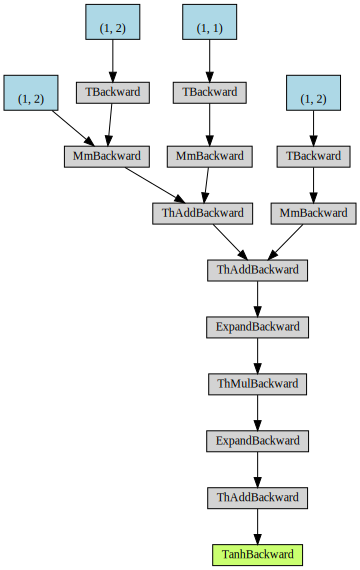

In [153]:
np.random.seed(3)
torch.manual_seed(3)
random.seed(3)

genome = Genotype(2,1)
genome.add_neuron(1,{(0,2):0,(1,2):1})
genome.add_neuron(3,{(0,2):0,(1,2):1,(0,3):2,(3,2):3})
#genome.add_neuron(5,{(0,2):0,(1,2):1,(0,3):2,(3,2):3,(1,4):4,(4,3):5})
print(genome.neuron_genes)
print(genome.connection_genes)

network = NeuralNetwork.create(genome)
output = network.activate(np.array([[0,1]]))
print(output)
make_dot(output)

# Tasks

In [121]:
class XORTask(object):
    
    # Default XOR input/output pairs
    INPUTS  = [(0,0), (0,1), (1,0), (1,1)]
    OUTPUTS = [(-1,), (1,), (1,), (-1,)]
    EPSILON = 1e-100
    
    def __init__(self, do_all=True):
        self.do_all = do_all
        self.INPUTS = np.array(self.INPUTS, dtype=float)
        self.OUTPUTS = np.array(self.OUTPUTS, dtype=float)
    
    def evaluate(self, network, verbose=False):
        if not isinstance(network, NeuralNetwork):
            network = NeuralNetwork.create(network)
            
#             network = NeuralNetwork2(network)
        
        pairs = list(zip(self.INPUTS, self.OUTPUTS))
        random.shuffle(pairs)
        if not self.do_all:
            pairs = [random.choice(pairs)]
        rmse = 0.0
        for (i, target) in pairs:
            # Feed with bias
#             output = network(torch.Tensor(i))
            output = network.activate(np.array([i]))
            err = (target - output.item())
            err[abs(err) < self.EPSILON] = 0;
            err = (err ** 2).mean()
            # Add error
            if verbose:
                print("%r -> %r (%.2f)" % (i, output, err))
            rmse += err 

        score = 1/(1+np.sqrt(rmse / len(pairs)))
        return {'fitness': score, 'info' : 0}
        
    def solve(self, network):
        return int(self.evaluate(network)['fitness'] > 0.9)

In [122]:
class RubiksTask(object):
    def __init__(self):
        self.difficulty = 1
        self.env = rubiks.RubiksEnv(2)
    
    def _increase_difficulty(self):
        self.difficulty += 1
    
    def evaluate(self, network, verbose=False):
        if not isinstance(network, NeuralNetwork):
            network = NeuralNetwork.create(network)
        
        fitness = 0.000001
        
        for i in range(100):
            done = False
            tries = 0
            
            max_tries = self.difficulty
            state = self.env.reset(self.difficulty)
            
            while tries < max_tries and not done:

                action_probabilities = network.activate(np.array([state]))
                action = np.argmax(action_probabilities)
                
                next_state, reward, done, info = self.env.step(int(action))
                
                tries += 1
                state = next_state
            if done:
                fitness += 1.0
                
        fitness = fitness / 100
        
        if fitness > 0.7:
            self._increase_difficulty()
        
        return {'fitness' : fitness, 'info' : self.difficulty}
        
    def solve(self, network):
        return int(self.evaluate(network)['fitness'] > 0.5)

In [123]:
inputs = 2
outputs = 1
nonlinearities = ['tanh','relu','sigmoid']
topology = None
feedforward = False
max_depth = None
max_nodes = float('inf')
response_default = 4.924273
bias_as_node = False
initial_weight_stdev = 2.0
p_add_neuron = 0.03
p_add_connection = 0.3
p_mutate_weight = 0.8
p_reset_weight = 0.1
p_reenable_connection = 0.01
p_disable_connection = 0.01
p_reenable_parent=0.25
p_mutate_bias = 0.2
p_mutate_response = 0.0
p_mutate_type = 0.2
stdev_mutate_weight = 1.5
stdev_mutate_bias = 0.5
stdev_mutate_response = 0.5
weight_range = (-50.,50.)

distance_excess_weight = 1.0
distance_disjoint_weight = 1.0
distance_weight = 0.4

In [125]:
population_size = 100
elitism = True
stop_when_solved = True 
tournament_selection_k = 3 
verbose = True
max_cores = 1
compatibility_threshold = 3.0
compatibility_threshold_delta = 0.4 
target_species = 12
minimum_elitism_size = 5 
young_age = 10
young_multiplier = 1.2 
old_age = 30
old_multiplier = 0.2 
stagnation_age = 15
reset_innovations = False
survival = 0.2

genome_factory = lambda: Genotype(inputs, outputs, nonlinearities, topology, feedforward,
                                  max_depth, max_nodes, response_default, initial_weight_stdev,
                                  bias_as_node, p_add_neuron, p_add_connection, p_mutate_weight, 
                                  p_reset_weight, p_reenable_connection, p_disable_connection,
                                  p_reenable_parent, p_mutate_bias, p_mutate_response, p_mutate_type,
                                  stdev_mutate_weight, stdev_mutate_bias, stdev_mutate_response,
                                  weight_range, distance_excess_weight, distance_disjoint_weight,
                                  distance_weight)

np.random.seed(420)
torch.manual_seed(420)

population = Population(genome_factory, population_size, elitism, stop_when_solved, tournament_selection_k, verbose, max_cores, compatibility_threshold, compatibility_threshold_delta, target_species, minimum_elitism_size, young_age, young_multiplier, old_age, old_multiplier, stagnation_age, reset_innovations, survival)
task = XORTask()
#task = RubiksTask()

# cProfile.run('population.epoch(evaluator = task, generations = 1, solution = task)', 'restats')
# import pstats
# p = pstats.Stats('restats')
# p.strip_dirs().sort_stats('cumtime').print_stats()
result = population.epoch(evaluator = task, generations = 1000, solution = task)


****** Running Generation 1 ******
****** Difficulty 0 ******
Population's average fitness: 0.43195 stdev: 0.00307
Best individual: vaughn kue
Best fitness: 0.44 - #neurons: 3 - #enabled connections: 2
Population of 100 members in 1 species:
Species         age    size    fitness    stag
============    ===    ====    =======    ====
         kue      0     100    0.43986       0
Generation time: 0 seconds
Solved in generation: None

****** Running Generation 2 ******
****** Difficulty 0 ******
Population's average fitness: 0.44234 stdev: 0.01294
Best individual: milla kue
Best fitness: 0.46 - #neurons: 3 - #enabled connections: 2
Population of 100 members in 2 species:
Species         age    size    fitness    stag
============    ===    ====    =======    ====
         kue      1      50    0.46382       0
       drapi      0      50    0.43106       0
Generation time: 0 seconds
Solved in generation: None

****** Running Generation 3 ******
****** Difficulty 0 ******
Population's av


****** Running Generation 10 ******
****** Difficulty 0 ******
Population's average fitness: 0.52157 stdev: 0.15206
Best individual: guad rettis
Best fitness: 1.00 - #neurons: 6 - #enabled connections: 7
Population of 102 members in 17 species:
Species         age    size    fitness    stag
============    ===    ====    =======    ====
         kue      9       6    0.99143       0
       drapi      8       6    0.50000       1
      rettis      7       6    0.99990       0
        sime      6       6    0.41642       1
        mccr      6       6    0.49991       0
          mu      6       6    0.50000       0
        seku      5       7    0.50000       0
        grit      4       7    0.49824       1
       thori      4       5    0.41421       2
          me      4       6    0.46377       1
          mi      4       5    0.41421       1
       spark      3       6    0.50000       1
   delliever      3       5    0.37116       3
       lesei      3       6    0.50000       1
  

# Legacy

In [ ]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask =  None, weights = None):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
        if mask is None:
            mask = torch.ones((out_features, in_features))
            
        if weights is not None:
            self.linear.weight.data = weights
            
        self.linear.weight.data *= mask
        
    def forward(self, x):
        return self.linear(x)
class NeuralNetwork2(nn.Module):
    def __init__(self, genome):
        super(NeuralNetwork2, self).__init__()
        self.genome = genome
        # Set maximum layer
        self.max_layer = genome.max_layer
        self.layers = defaultdict(list)
        
        # How many neurons in each layer?
        for neuron_gene in genome.neuron_genes:
            self.layers[neuron_gene[3]].append(neuron_gene)
            
        input_keys = genome.input_keys
        output_keys = genome.output_keys
        
        # Hidden neuron id to layer
        hidden_key_to_layer = defaultdict(int)
        
        all_hidden_keys = [k[0] for k in genome.neuron_genes if k[0] not in output_keys and k[0] not in input_keys]
        self.hidden_keys = defaultdict(list)
        for k in genome.neuron_genes:
            if k[0] not in output_keys and k[0] not in input_keys:
                self.hidden_keys[k[3]].append(k[0])
                hidden_key_to_layer[k[0]] = k[3]
        
        input_key_to_idx = {k: i for i, k in enumerate(input_keys)}
        hidden_key_to_idx = defaultdict(list)
        
        for hk in self.layers.keys():
            if hk is not 0 and hk is not self.max_layer:
                hidden_key_to_idx[hk].append({k: i for i, k in enumerate(self.hidden_keys[hk])})
        
        output_key_to_idx = {k: i for i, k in enumerate(output_keys)}
    
        def key_to_idx(key, layer = None):
            if layer is None and key in input_keys:
                return input_key_to_idx[key]
            elif layer is not None and key in self.hidden_keys[layer]:
                return hidden_key_to_idx[layer][0][key]
            elif layer is None and key in output_keys:
                return output_key_to_idx[key]
        
        self.i2o_mask = None
        self.i2h_masks = defaultdict(list)
        self.h2h_masks = defaultdict(list)
        self.h2o_masks = defaultdict(list)
        
        self.i2o_weights = None
        self.i2h_weights = defaultdict(list)
        self.h2h_weights = defaultdict(list)
        self.h2o_weights = defaultdict(list)
        
#         self.i2o_bias = None
#         self.i2h_bias = defaultdict(list)
#         self.h2h_bias = defaultdict(list)
#         self.h2o_bias = defaultdict(list)
        
        for connection_gene in genome.connection_genes:
            # Format (input_key, output_key)
            input_key, output_key = connection_gene
            # Format innovation_number, input, output, weight, enabled
            weight, enabled = genome.connection_genes[connection_gene][3:]
            
            # Input to Output (I2O)
            if input_key in input_keys and output_key in output_keys:
                input_key_idx = key_to_idx(input_key)
                output_key_idx = key_to_idx(output_key)
                
                if self.i2o_mask is None:
                    self.i2o_mask = torch.zeros((len(self.layers[self.max_layer]),len(self.layers[0])))
                
                if self.i2o_weights is None:
                    self.i2o_weights = torch.zeros((len(self.layers[self.max_layer]),len(self.layers[0])))
                    
#                 if self.i2o_bias is None:
#                     self.i2o_bias = torch.zeros([1])
                    
                if enabled:
                    self.i2o_mask[output_key_idx,input_key_idx] = 1
                self.i2o_weights[output_key_idx,input_key_idx] = weight
#                 self.i2o_bias = bias
                
            # Input to Hidden (I2H)
            if input_key in input_keys and output_key in all_hidden_keys:
                input_key_idx = key_to_idx(input_key)
                layer = hidden_key_to_layer[output_key]
                output_key_idx = key_to_idx(output_key, layer)
                
                if not self.i2h_masks[layer]:
                    self.i2h_masks[layer].append(torch.zeros((len(self.layers[layer]), len(self.layers[0]))))
                    
                if not self.i2h_weights[layer]:
                    self.i2h_weights[layer].append(torch.zeros((len(self.layers[layer]),len(self.layers[0]))))
                    
                if enabled:
                    self.i2h_masks[layer][0][output_key_idx,input_key_idx] = 1
                    
                self.i2h_weights[layer][0][output_key_idx,input_key_idx] = weight
                
            # Hidden to Output (H2O)
            if input_key in all_hidden_keys and output_key in output_keys:
                layer = hidden_key_to_layer[input_key]
                input_key_idx = key_to_idx(input_key, layer)
                output_key_idx = key_to_idx(output_key)
                
                if not self.h2o_masks[layer]:
                    self.h2o_masks[layer].append(torch.zeros((len(self.layers[self.max_layer]), len(self.layers[layer]))))
                    
                if not self.h2o_weights[layer]:
                    self.h2o_weights[layer].append(torch.zeros((len(self.layers[self.max_layer]),len(self.layers[layer]))))
                    
                if enabled:
                    self.h2o_masks[layer][0][output_key_idx,input_key_idx] = 1
                
                self.h2o_weights[layer][0][output_key_idx,input_key_idx] = weight
                
            # Hidden to Hidden (H2H)
            if input_key in all_hidden_keys and output_key in all_hidden_keys:
                layer = hidden_key_to_layer[input_key]
                layer_output = hidden_key_to_layer[output_key]
                input_key_idx = key_to_idx(input_key, layer)
                output_key_idx = key_to_idx(output_key, layer_output)
                
                if not self.h2h_masks[(layer, layer_output)]:
                    self.h2h_masks[(layer, layer_output)].append(torch.zeros((len(self.layers[layer_output]), len(self.layers[layer]))))
                    
                if not self.h2h_weights[(layer, layer_output)]:
                    self.h2h_weights[(layer, layer_output)].append(torch.zeros((len(self.layers[layer_output]), len(self.layers[layer]))))
                    
                if enabled:
                    self.h2h_masks[(layer, layer_output)][0][output_key_idx,input_key_idx] = 1
                
                self.h2h_weights[(layer, layer_output)][0][output_key_idx,input_key_idx] = weight
        
        self.input_to_output = MaskedLinear(len(self.layers[0]), len(self.layers[self.max_layer]), self.i2o_mask, self.i2o_weights)
        
        self.input_to_hidden = {layer: MaskedLinear(len(self.layers[0]), len(self.layers[layer]), self.i2h_masks[layer][0], self.i2h_weights[layer][0]) for layer in sorted(list(self.hidden_keys.keys())) if self.i2h_masks[layer]}
        
        self.hidden_to_hidden = {keys : MaskedLinear(len(self.layers[keys[0]]), len(self.layers[keys[1]]), self.h2h_masks[keys][0], self.h2h_weights[keys][0]) for keys in self.h2h_masks.keys()}
        
        self.hidden_to_output = {layer: MaskedLinear(len(self.layers[layer]), len(self.layers[self.max_layer]), self.h2o_masks[layer][0], self.h2o_weights[layer][0]) for layer in sorted(list(self.hidden_keys.keys())) if self.h2o_masks[layer]}     
        
    def forward(self, x):
        #order layers
        sorted_layer_keys = sorted(self.layers.keys())
        
        original_input = x
        
        input_nonlinearities = [string_to_activation[neuron_gene[1]] for neuron_gene in self.layers[0]]
        input_after_non_linearity = torch.cat(([input_nonlinearities[i](input_x).view(1) for i, input_x in enumerate(original_input)]), dim = 0)
        
        past_hidden_activations = defaultdict(list)
        # Iterate over each hidden layer
        for idx, l in enumerate(sorted_layer_keys[1:-1]):
            hidden_nonlinearities = [string_to_activation[neuron_gene[1]] for neuron_gene in self.layers[l]]
            
            total = torch.zeros([len(self.hidden_keys[l])])
            
            if l in self.input_to_hidden.keys():
                total += self.input_to_hidden[l](input_after_non_linearity)
            
            for keys in self.hidden_to_hidden:
                if keys[1] == l:

                    total += self.hidden_to_hidden[keys](past_hidden_activations[keys[0]])
            
            hidden_after_nonlinearity = torch.cat(([hidden_nonlinearities[i](input_x).view(1) for i, input_x in enumerate(total)]), dim = 0)
            past_hidden_activations[l] = hidden_after_nonlinearity

        total = torch.zeros([len(self.layers[self.max_layer])])    
        total += self.input_to_output(input_after_non_linearity)
        
        for keys in self.hidden_to_output:
            total += self.hidden_to_output[keys](past_hidden_activations[keys])
        
        output_nonlinearities = [string_to_activation[neuron_gene[1]] for neuron_gene in self.layers[self.max_layer]]
        final_output = torch.cat(([output_nonlinearities[i](input_x).view(1) for i, input_x in enumerate(total)]), dim = 0)    
        
        return final_output